# CommonShare Data Science Internship Technical Assessment — Summer 2025

---

## Task 1: Sentiment Analysis

**Objective:**  
Build a sentiment analysis model to classify product reviews as **positive**, **neutral**, or **negative** based on the review text.

---

### Steps:

1. **Load and Explore the Dataset**  
2. **Map Numerical Scores to Sentiment Labels**  
3. **Preprocess Text Data**  
4. **Convert Text to Features using TF-IDF Vectorization**  
5. **Split Data into Training and Testing Sets**  
6. **Train a Support Vector Machine (SVM) Classifier**  
7. **Evaluate Model Performance (Precision, Recall, F1-score)**  
8. **Visualize Results (Confusion Matrix, Sample Predictions)**


# 1. Import libraries and load the dataset



**Importing libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**load dataset**

In [3]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Exploring Dataset**

In [4]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


In [5]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [6]:
print("\nSample reviews:")
print(df.sample(5)[['Score', 'Summary', 'Text']])


Sample reviews:
        Score                                            Summary  \
174118      5                               pleasantly surprised   
370246      5                                   reallllllly good   
350900      5  excellent gluten-free spaghetti: great taste, ...   
370411      5                               fat freehot coca mix   
151033      5                     great snack for baby and adult   

                                                     Text  
174118  i've often used instant coffee in a jar since ...  
370246  first of all -- they're good.  really good.  g...  
350900  I was very careful not to overcook this pasta,...  
370411  I've been buying Nestle's fat free hot coca fo...  
151033  My baby started to eat this snack when she was...  


# 2. Map Numerical Scores to Sentiment Labels  


In [7]:
def map_score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'
df['Sentiment'] = df['Score'].apply(map_score_to_sentiment)
print(df['Sentiment'].value_counts())


Sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64


In [8]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


# 3. Preprocess Text Data  


In [9]:
import re
import string

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    return text

In [10]:
df['Clean_Text'] = df['Text'].apply(preprocess_text)
df[['Text', 'Clean_Text']].head()

,Text,Clean_Text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide...


# 4. Convert Text to Features using TF-IDF Vectorization

In [10]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X = vectorizer.fit_transform(df['Clean_Text'])
print(f"TF-IDF feature matrix shape: {X.shape}")

TF-IDF feature matrix shape: (568454, 10000)


In [11]:
print(vectorizer.get_feature_names_out()[:20])  # first 20 words


['aa' 'ab' 'abdominal' 'ability' 'able' 'aboutbr' 'abovebr' 'abr' 'abroad'
 'absence' 'absent' 'absolute' 'absolutely' 'absolutly' 'absorb'
 'absorbed' 'absorbs' 'absorption' 'absurd' 'abundance']


#  5. Split the data into training and testing sets 

In [31]:
df['Index'] = df.index
X = vectorizer.fit_transform(df['Clean_Text'])
y = df['Sentiment']
indices = df['Index']


In [32]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)
X_test_indices = idx_test.reset_index(drop=True)


# 6. Train a Support Vector Machine (SVM) Classifier


In [34]:
svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train, y_train)

print("SVM training completed.")


SVM training completed.


# 7. Evaluate Model Performance (Precision, Recall, F1-score) 


In [35]:
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.74      0.69      0.71     16407
     neutral       0.62      0.15      0.24      8528
    positive       0.90      0.97      0.93     88756

    accuracy                           0.87    113691
   macro avg       0.75      0.60      0.63    113691
weighted avg       0.85      0.87      0.85    113691



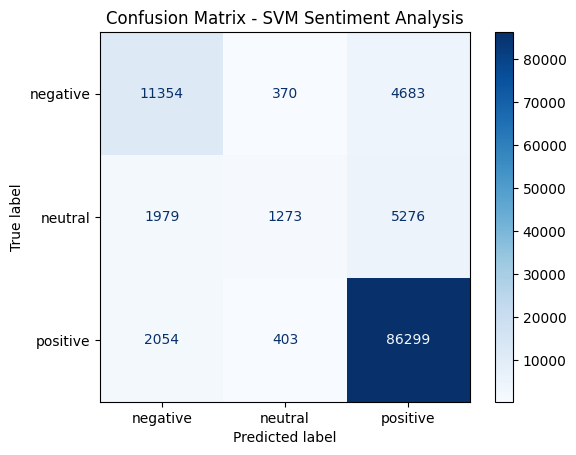

In [36]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM Sentiment Analysis")
plt.show()

**Sample Predictions**

In [37]:
import random

random_indices = random.sample(range(X_test.shape[0]), 5)

for idx in random_indices:
    original_idx = X_test_indices[idx]
    
    print("="*100)
    print("Original Review:")
    print(df.loc[original_idx, 'Text'][:500])
    print("\nCleaned Review:")
    print(df.loc[original_idx, 'Clean_Text'][:500])
    print(f"\nTrue Sentiment: {y_test.iloc[idx]}")
    print(f"Predicted Sentiment: {y_pred[idx]}")

Original Review:
My 6 month old kittens won't touch Wellness Kitten canned food.  I'm sure it's good for them but I can't get them to eat it.  I've tried on 2 separate occasions without any success.  One of my kittens is very finicky but the other one eats almost anything so I've given up on this brand.

Cleaned Review:
my  month old kittens wont touch wellness kitten canned food  im sure its good for them but i cant get them to eat it  ive tried on  separate occasions without any success  one of my kittens is very finicky but the other one eats almost anything so ive given up on this brand

True Sentiment: negative
Predicted Sentiment: positive
Original Review:
I always enjoyed this product although the box seems to have shrunk. But now very disappointed the product has been dropped from the Subscribe & Save program. Why is that?

Cleaned Review:
i always enjoyed this product although the box seems to have shrunk but now very disappointed the product has been dropped from the subscrib

# Task 2: Topic Modeling
Objective:
Identify key topics discussed in the product reviews using Latent Dirichlet Allocation (LDA) and provide a summary of the identified topics.

**Steps:**

**1.Prepare the Text Data
Use the cleaned review texts (Clean_Text column) from Task 1 for analysis.**

**2.Create Document-Term Matrix
Convert the cleaned texts into a bag-of-words representation suitable for LDA.**

**3.Apply LDA Model
Use Latent Dirichlet Allocation to discover latent topics in the reviews.**

**4.Interpret Topics
Extract and analyze the top words per topic to understand the main themes in the reviews.**

**5.Summarize Topics
Provide a brief summary describing each identified topic based on its top keywords.**

**1.Prepare the Text Data
Use the cleaned review texts (Clean_Text column) from Task 1 for analysis.**

In [38]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [39]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [41]:
def preprocess_for_lda(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 3]
    return tokens

In [42]:
df['Tokens'] = df['Clean_Text'].apply(preprocess_for_lda)
df[['Clean_Text', 'Tokens']].head()

,Clean_Text,Tokens
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, food, prod..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, century, light, pillowy, ..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wide...,"[great, taffy, great, price, wide, assortment,..."


**2.Create Document-Term Matrix Convert the cleaned texts into a bag-of-words representation suitable for LDA.**

In [43]:
import gensim
from gensim import corpora

In [46]:
dictionary = corpora.Dictionary(df['Tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [47]:
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

In [48]:
# printing a sample 
print(f"Example document (BoW): {corpus[0][:10]}")
print(f"Number of unique tokens: {len(dictionary)}")
print(f"Number of documents: {len(corpus)}")

Example document (BoW): [(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
Number of unique tokens: 31547
Number of documents: 568454


**3.Apply LDA Model
Use Latent Dirichlet Allocation to discover latent topics in the reviews.**

In [49]:
from gensim.models.ldamodel import LdaModel

# setting number o topics to 10
NUM_TOPICS = 10

# Train of lda model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    update_every=1,
    chunksize=10000,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

**4.Interpret Topics
Extract and analyze the top words per topic to understand the main themes in the reviews.**

In [51]:
print("Top 10 words per topic:\n")
for i, topic in lda_model.show_topics(num_topics=10, num_words=10, formatted=True):
    print(f"Topic {i+1}: {topic}")
    print('-' * 80)

Top 10 words per topic:

Topic 1: 0.067*"food" + 0.013*"cat" + 0.009*"baby" + 0.009*"ingredient" + 0.007*"year" + 0.007*"like" + 0.006*"would" + 0.006*"dog" + 0.006*"formula" + 0.006*"diet"
--------------------------------------------------------------------------------
Topic 2: 0.024*"sauce" + 0.017*"salt" + 0.015*"make" + 0.013*"soup" + 0.012*"rice" + 0.011*"chicken" + 0.010*"pasta" + 0.010*"cheese" + 0.009*"cook" + 0.009*"pepper"
--------------------------------------------------------------------------------
Topic 3: 0.050*"treat" + 0.019*"love" + 0.018*"dog" + 0.011*"chew" + 0.010*"hair" + 0.009*"small" + 0.009*"like" + 0.008*"time" + 0.008*"size" + 0.008*"keep"
--------------------------------------------------------------------------------
Topic 4: 0.022*"product" + 0.013*"would" + 0.010*"review" + 0.009*"received" + 0.009*"package" + 0.008*"ordered" + 0.008*"time" + 0.007*"order" + 0.007*"first" + 0.006*"packaging"
---------------------------------------------------------------

In [52]:
import pandas as pd
topics_per_doc = lda_model.get_document_topics(corpus)
dominant_topics = []

for i, topic_probs in enumerate(topics_per_doc):
    sorted_probs = sorted(topic_probs, key=lambda x: x[1], reverse=True)
    dominant_topic, contribution = sorted_probs[0]
    dominant_topics.append((i, dominant_topic, round(contribution, 4)))
dominant_topic_df = pd.DataFrame(dominant_topics, columns=['Document_No', 'Dominant_Topic', 'Topic_Prob'])
dominant_topic_df = dominant_topic_df.join(df[['Clean_Text']], how='left')
print(dominant_topic_df.head(10))


   Document_No  Dominant_Topic  Topic_Prob  \
0            0               0      0.5107   
1            1               4      0.3744   
2            2               9      0.3331   
3            3               8      0.6474   
4            4               4      0.5456   
5            5               5      0.3583   
6            6               5      0.5545   
7            7               5      0.7847   
8            8               0      0.4777   
9            9               0      0.7642   

                                          Clean_Text  
0  i have bought several of the vitality canned d...  
1  product arrived labeled as jumbo salted peanut...  
2  this is a confection that has been around a fe...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price  there was a wide...  
5  i got a wild hair for taffy and ordered this f...  
6  this saltwater taffy had great flavors and was...  
7  this taffy is so good  it is very soft and che... 


**5.Summarize Topics
Provide a brief summary describing each identified topic based on its top keywords.**

In [55]:
num_top_words = 10
for i, topic in lda_model.show_topics(formatted=False, num_words=num_top_words):
    print(f"Topic {i+1}:")
    words = [word for word, prob in topic]
    print(", ".join(words))
    print()


Topic 1:
food, cat, baby, ingredient, year, like, would, dog, formula, diet

Topic 2:
sauce, salt, make, soup, rice, chicken, pasta, cheese, cook, pepper

Topic 3:
treat, love, dog, chew, hair, small, like, time, size, keep

Topic 4:
product, would, review, received, package, ordered, time, order, first, packaging

Topic 5:
price, amazon, great, product, store, love, find, good, best, time

Topic 6:
like, taste, flavor, good, really, love, dont, would, chip, sweet

Topic 7:
snack, sugar, calorie, bar, protein, cereal, popcorn, healthy, ingredient, serving

Topic 8:
coffee, flavor, like, strong, blend, taste, roast, good, kcups, bean

Topic 9:
water, drink, taste, green, bottle, sugar, flavor, tea, make, like

Topic 10:
chocolate, cooky, butter, peanut, milk, coconut, make, cookie, free, gluten



# Task 3: Named Entity Recognition (NER)
**Objective:
Extract named entities such as product names, locations, and organizations from the review text, and visualize them using spaCy's displaCy or a similar tool.**

**Step 1: Load spaCy and the Language Model**

**Step 2: Apply NER on Sample Reviews**

**Step 3: Visualize Entities with displaCy**

**Step 4: Extract Entities from Multiple Reviews**




**-------------------------------------------**

**Step 1: Load spaCy and the Language Model**


In [49]:
!python -m spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.1 MB/s eta 0:00:000:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [50]:
import spacy

nlp = spacy.load("en_core_web_lg")

**Step 2: Apply NER on Sample Reviews**


In [51]:

sample_text = df['Text'].loc[2]


doc = nlp(sample_text)

for ent in doc.ents:
    print(ent.text, ":", ent.label_)


around a few centuries : DATE
C.S. Lewis' : PERSON
The Lion, The Witch : WORK_OF_ART
Edmund : PERSON


**Step 3: Visualize Entities with displaCy**


In [52]:
from spacy import displacy

displacy.render(doc, style="ent", jupyter=True)


In [58]:

sample_text = df['Text'].iloc[25]


doc = nlp(sample_text)

for ent in doc.ents:
    print(ent.text, "-", ent.label_)


Strawberry - PERSON
16-Ounce Bags - QUANTITY


In [59]:
displacy.render(doc, style="ent", jupyter=True)


In [67]:

sample_text = df['Text'].iloc[222]


doc = nlp(sample_text)

for ent in doc.ents:
    print(ent.text, "-", ent.label_)


dozens - CARDINAL
Russian - NORP
the Ahmad Imperial - FAC
three - CARDINAL
Amazon - ORG
one - CARDINAL


In [70]:
displacy.render(doc, style="ent", jupyter=True)


**Step 4: Extract Entities from Multiple Reviews**

In [22]:
all_entities = []

for text in df['Text'].sample(200):  # a sample of 200
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    all_entities.extend(entities)

import pandas as pd
entities_df = pd.DataFrame(all_entities, columns=["Entity", "Label"])
entities_df["Label"].value_counts()


Label
ORG            156
CARDINAL       149
PERSON         107
DATE            66
GPE             44
NORP            42
ORDINAL         32
TIME            23
MONEY           19
QUANTITY        17
PRODUCT         12
WORK_OF_ART     10
LOC              8
PERCENT          5
FAC              4
LAW              2
EVENT            1
Name: count, dtype: int64

# **Task 4: Text Summarization**

**Objective:**  
Develop an extractive summarization model to generate concise summaries of longer product reviews.

---

## **Steps:**

### **1. Select Review Texts**  

### **2. Apply Extractive Summarization**  

### **3. Generate Summaries**  

### **4. Compare with Human-Written Summaries**  


**----------------------------------------------**

 **1. Select Review Texts**  


In [71]:
df['Text'].dropna().sample(3, random_state=42).tolist()


['Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch.  They\'re crunchy and true to the texture of the other "real" cookies that aren\'t gluten-free.  Some might think that the filling makes them a bit too sweet, but for me that just means I\'ve satisfied my sweet tooth sooner!  The chocolate version from Glutino is just as good and has a true "chocolatey" taste - something that isn\'t there with the other gluten-free brands out there.',
 "My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so these are perfect for her. I've given her all three flavors and she seems to like them all equally. They do tend to dry out by the time I near the end of the bottle, however. The flip-top lid is very handy. Very nice, inexpensive kitty treats. I have yet to meet a cat that doesn't just love these!",
 'A little 

**2. Apply Extractive Summarization**  


In [73]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.8 MB/s eta 0:00:00:00:010:01
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=cdea79e917d257c14941a10262b8b2140b7b1943c573c32222823c32786486da
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=d8e5cafc3063fbdbf3b6e9691576c89535c80181d61e808fe202ed18b9b9b2dc
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [92]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer 

In [83]:
# Example review
example_text = df['Text'].dropna().iloc[2]  
print("Original text review : \n",example_text)

parser = PlaintextParser.from_string(example_text, Tokenizer("english"))

summarizer = LsaSummarizer()

summary = summarizer(parser.document, 2)
print("---------------------------------------\n Summary:",)

for sentence in summary:
    print(sentence)


Original text review : 
 This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
---------------------------------------
 Summary:
It is a light, pillowy citrus gelatin with nuts - in this case Filberts.
And it is a tiny mouthful of heaven.


In [91]:
# Example review
example_text = df['Text'].dropna().iloc[29] 
print("Original text review : \n",example_text)

parser = PlaintextParser.from_string(example_text, Tokenizer("english"))

summarizer = LsaSummarizer()

summary = summarizer(parser.document, 2)
print("---------------------------------------\n Summary:",)
for sentence in summary:
    print(sentence)


Original text review : 
 I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!
---------------------------------------
 Summary:
We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!
When we realized that we simply cou

 **3. Generate Summaries**  


In [93]:
def extractive_summary(text, num_sentences=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# we apply this to a sample of 10 reviews
df_sample = df[['Text', 'Summary']].dropna().sample(10, random_state=42)
df_sample['Extractive_Summary'] = df_sample['Text'].apply(lambda x: extractive_summary(x, num_sentences=2))

# Show examples
df_sample[['Text', 'Summary', 'Extractive_Summary']]

,Text,Summary,Extractive_Summary
41434,These are actually very tasty. Pure potatoes ...,I like these!,I add a touch of either salt & pepper or fajit...
209481,I realize that taste is a matter of personal p...,Good but subjectively not 5 star,I realize that taste is a matter of personal p...
247306,This is one of my Favorite cup of soup choices...,"Lipton Cup A Soup, Spring Vegetable.4 oz",It's resonably priced and each box contains 4-...
80089,If you like the classic taste of a good margar...,"Suited to its purpose, if not quite its goal...",If you like the classic taste of a good margar...
218580,I was willing to give this a chance even after...,Tastes artificial!,"After cooling it down some, I made my first gl..."
399096,can't keep enough of these treats in the house...,dog loves chicken fillets,can't keep enough of these treats in the house...
16538,I LOVE this stuff. Imagine my joy to find it i...,"Chipotle Tabasco sauce, how do I love thee?....",Imagine my joy to find it in a gallon sized co...
34007,Recommend it to all. Lovely natural sweet del...,Dbp323,Lovely natural sweet delicate flavor and add s...
469948,A totally wonderful product! The flavor is in...,Heavenly hot dogs!,It's more than wonderful on corned beef or pas...
497875,TOTALLY ORGASMIC. these chips are the best sp...,spicy thai chips,these chips are the best spicy chip i have eve...


 **4. Compare with Human-Written Summaries**  


In [99]:
# Show side-by-side comparisons
df_sample[['Summary', 'Extractive_Summary']]


,Summary,Extractive_Summary
41434,I like these!,I add a touch of either salt & pepper or fajit...
209481,Good but subjectively not 5 star,I realize that taste is a matter of personal p...
247306,"Lipton Cup A Soup, Spring Vegetable.4 oz",It's resonably priced and each box contains 4-...
80089,"Suited to its purpose, if not quite its goal...",If you like the classic taste of a good margar...
218580,Tastes artificial!,"After cooling it down some, I made my first gl..."
399096,dog loves chicken fillets,can't keep enough of these treats in the house...
16538,"Chipotle Tabasco sauce, how do I love thee?....",Imagine my joy to find it in a gallon sized co...
34007,Dbp323,Lovely natural sweet delicate flavor and add s...
469948,Heavenly hot dogs!,It's more than wonderful on corned beef or pas...
497875,spicy thai chips,these chips are the best spicy chip i have eve...


In [108]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Example evaluation for one row
for i, row in df_sample.iterrows():
    scores = scorer.score(str(row['Summary']), str(row['Extractive_Summary']))
    print(f"Review {i} - ROUGE Scores: {scores}")


Review 41434 - ROUGE Scores: {'rouge1': Score(precision=0.03333333333333333, recall=0.3333333333333333, fmeasure=0.0606060606060606), 'rougeL': Score(precision=0.03333333333333333, recall=0.3333333333333333, fmeasure=0.0606060606060606)}
Review 209481 - ROUGE Scores: {'rouge1': Score(precision=0.022222222222222223, recall=0.16666666666666666, fmeasure=0.0392156862745098), 'rougeL': Score(precision=0.022222222222222223, recall=0.16666666666666666, fmeasure=0.0392156862745098)}
Review 247306 - ROUGE Scores: {'rouge1': Score(precision=0.07894736842105263, recall=0.375, fmeasure=0.13043478260869565), 'rougeL': Score(precision=0.05263157894736842, recall=0.25, fmeasure=0.08695652173913043)}
Review 80089 - ROUGE Scores: {'rouge1': Score(precision=0.04, recall=0.3333333333333333, fmeasure=0.07142857142857142), 'rougeL': Score(precision=0.02666666666666667, recall=0.2222222222222222, fmeasure=0.047619047619047616)}
Review 218580 - ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeas

# **Abstractive Summarization using Hugging Face Transformers (bart-large-cnn model)**


In [114]:
from transformers import pipeline

In [113]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

sample_indices = [0, 1, 2]  
for idx in sample_indices:
    review_text = df.iloc[idx]['Text']
    human_summary = df.iloc[idx]['Summary']

    bart_summary = summarizer(review_text, max_length=60, min_length=15, do_sample=False)[0]['summary_text']

    print(f"\n--- Review ID: {df.iloc[idx]['Id']} ---")
    print("Original Review Text:\n", review_text)
    print("\nHuman-Written Summary:\n", human_summary)
    print("\nGenerated Summary (BART):\n", bart_summary)
    print("-" * 80)

Device set to use cuda:0
Your max_length is set to 60, but your input_length is only 57. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=28)
Your max_length is set to 60, but your input_length is only 43. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)



--- Review ID: 1 ---
Original Review Text:
 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Human-Written Summary:
 Good Quality Dog Food

Generated Summary (BART):
 The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
--------------------------------------------------------------------------------

--- Review ID: 2 ---
Original Review Text:
 Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Human-Written Summary:
 Not as Advertised

Generated Summary (BART):
 Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually